In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import average_precision_score


In [29]:
df_power = pd.read_csv('mean_power.csv', sep=',', index_col =0 )


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [30]:
df_power['DateTime'] = pd.to_datetime(df_power['DateTime'])
df_power.dtypes



Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
DateTime                 datetime64[ns]
dtype: object

In [31]:
df_power.reset_index().set_index('DateTime')

,index,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,,
2006-12-16 17:24:00,1,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,2,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,3,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,4,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,5,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,2075255,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,2075256,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,2075257,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [32]:
df_power.info()
df_power.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075259 entries, 1 to 2075259
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   DateTime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 142.5 MB


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


In [33]:
df_power_hourly=df_power.resample('H', on='DateTime').mean()

In [34]:
GAP_test= df_power_hourly['Global_active_power']

In [35]:
pip install pykalman


In [36]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=1)    # A small turbulence in the random walk parameter 1.0
# Get the Kalman smoothing
state_means, _ = kf.filter(GAP_test.values)

# Call it KF_mean
GAP_kf = np.array(state_means)
GAP_kf

array([[2.11144444],
       [3.02389778],
       [3.25548889],
       ...,
       [1.61281412],
       [1.33524633],
       [1.08767448]])

In [37]:
# calculate RMSE

rmse = np.sqrt(mean_squared_error(GAP_test, GAP_kf))
print('RMSE value : {}'.format(rmse))

# calculate R2 Score
r2 = r2_score(GAP_test, GAP_kf)
print("R2 Score : {}".format(r2))

RMSE value : 0.26505287999762733
R2 Score : 0.9121607695348571


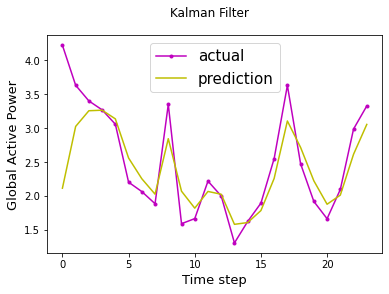

In [40]:
ap=[x for x in range(24)]
plt.plot(ap, GAP_test[:24], marker='.', color='m', label="actual")
plt.plot(ap, GAP_kf[:24],color='y', label="prediction")
plt.ylabel('Global Active Power', size=13)
plt.xlabel('Time step', size=13)
plt.legend(fontsize=15)
plt.suptitle("Kalman Filter")
plt.show()